In [1]:
#Load Libraries
import pandas as pd
import sqlite3 as sqlite3
import numpy as np
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from sklearn.experimental import enable_iterative_imputer 
from sklearn.impute import IterativeImputer

In [2]:
# Load the data into a DataFrame

con = sqlite3.connect("data/wildfire.sqlite")
fires = pd.read_sql_query(
    "select NWCG_REPORTING_AGENCY,CONT_DATE - DISCOVERY_DATE as CONT_DUR, \
    LONGITUDE,LATITUDE,OWNER_CODE,SOURCE_SYSTEM_TYPE,DISCOVERY_DATE,\
    DISCOVERY_DOY,STAT_CAUSE_DESCR,FIRE_SIZE from fires", con)
con.close()

In [3]:
fires.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1880465 entries, 0 to 1880464
Data columns (total 10 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   NWCG_REPORTING_AGENCY  object 
 1   CONT_DUR               float64
 2   LONGITUDE              float64
 3   LATITUDE               float64
 4   OWNER_CODE             float64
 5   SOURCE_SYSTEM_TYPE     object 
 6   DISCOVERY_DATE         float64
 7   DISCOVERY_DOY          int64  
 8   STAT_CAUSE_DESCR       object 
 9   FIRE_SIZE              float64
dtypes: float64(6), int64(1), object(3)
memory usage: 143.5+ MB


In [4]:
fires = fires.drop_duplicates()
fires.shape

(1874345, 10)

In [5]:
fires1 = fires[(fires["STAT_CAUSE_DESCR"] != "Missing/Undefined") & (fires["STAT_CAUSE_DESCR"] != "Miscellaneous")]
fires1.shape

(1385751, 10)

<AxesSubplot:>

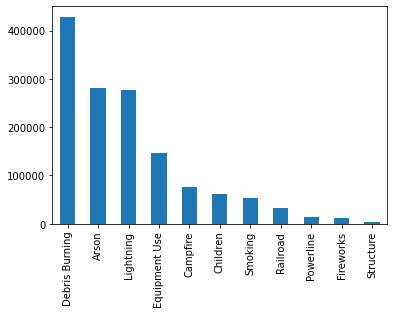

In [6]:
fires1["STAT_CAUSE_DESCR"].value_counts().plot.bar()


In [7]:
xFires=fires1.loc[:,fires1.columns != 'STAT_CAUSE_DESCR']
yFires=fires1['STAT_CAUSE_DESCR']
xFires=pd.get_dummies(xFires, columns=['NWCG_REPORTING_AGENCY', 'SOURCE_SYSTEM_TYPE', 'OWNER_CODE'])

#Training and test set split
xTrain,xTest,yTrain,yTest=train_test_split(xFires,yFires,\
                           test_size=0.1,random_state =441)

xTrain.shape
# yTrain.shape

(1247175, 35)

In [8]:
imp_mean = IterativeImputer(random_state=441)

In [9]:
%%time
imp_mean.fit(xTrain)

Wall time: 11min 13s


array([[ 0.00000000e+00, -8.93985280e+01,  4.06331250e+01, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 7.49437180e-01, -7.58840900e+01,  3.82858300e+01, ...,
         0.00000000e+00,  1.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00, -9.53336000e+01,  3.48001000e+01, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       ...,
       [ 1.15485385e-01, -8.32778487e+01,  3.22967444e+01, ...,
         0.00000000e+00,  1.00000000e+00,  0.00000000e+00],
       [ 4.00000000e+00, -1.16393889e+02,  4.70102778e+01, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 1.97334174e-01, -8.07528300e+01,  3.27458900e+01, ...,
         0.00000000e+00,  1.00000000e+00,  0.00000000e+00]])

In [10]:
%%time
xTrain_impute=imp_mean.transform(xTrain)
xTest_impute=imp_mean.transform(xTest)

Wall time: 2.02 s


In [28]:
train_impute_df=pd.DataFrame(xTrain_impute, columns=xTrain.columns)
train_impute_df['STAT_CAUSE_DESCR']=yTrain.reset_index(drop=True)

In [30]:
test_impute_df=pd.DataFrame(xTest_impute, columns=xTest.columns)
test_impute_df['STAT_CAUSE_DESCR']=yTest.reset_index(drop=True)

In [33]:
%%time
train_impute_df.to_csv('imputed_training_data.csv', index=False)
test_impute_df.to_csv('imputed_test_data.csv', index=False)

Wall time: 42.9 s
